In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys

import h5py

from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as units

import healpy as hp

sys.path.insert(0, '/global/homes/q/qmxp55/DESI/bgstargets/py')

from io_ import get_reg


## DATASETS

In [3]:
#``` python 

filename = '/global/cscratch1/sd/qmxp55/bgstargets_output/MXXL/galaxy_catalogue_sat_blue_10_percent.hdf5'
name = 'sat_blue_10_percent'

data = h5py.File(filename, "r")['Data']
header = h5py.File(filename, "r")['Header']

#
mxxl = Table()
for col in ['ra', 'dec', 'app_mag', 'g_r_obs_smooth']:
    
    mxxl[col] = data[col][:]
    
nside = 256
extra = Table()
extra['hppix'] = hp.ang2pix(nside,(90.-mxxl['dec'])*np.pi/180.,mxxl['ra']*np.pi/180.,nest=True)
print('healpix DONE...')
c = SkyCoord(mxxl['ra']*units.degree,mxxl['dec']*units.degree, frame='icrs')
extra['b'] = c.galactic.b.value # galb coordinate
extra['l'] = c.galactic.l.value # galb coordinate
print('galactic coordinates DONE...')

regs = ['des', 'decals', 'north', 'desi', 'south']
for i in regs:
    reg_ = get_reg(reg=i, hppix=extra['hppix'])
    extra[i] = reg_
    print(i, 'DONE...')
    
np.save('/global/cscratch1/sd/qmxp55/bgstargets_output/MXXL/galaxy_catalogue_extra_%s.npy' %(name), extra)

mxxl2 = Table()
mask = (extra['south']) & (extra['desi'])
for col in ['ra', 'dec', 'app_mag', 'g_r_obs_smooth']:
    
    mxxl2[col.upper()] = mxxl[col][mask]
    
np.save('/global/cscratch1/sd/qmxp55/bgstargets_output/MXXL/galaxy_catalogue_south_%s.npy' %(name), mxxl2)
print('south DONE...')

mxxlN = Table()
mask = (extra['north']) & (extra['desi'])
for col in ['ra', 'dec', 'app_mag', 'g_r_obs_smooth']:

    mxxlN[col.upper()] = mxxl[col][mask]

np.save('/global/cscratch1/sd/qmxp55/bgstargets_output/MXXL/galaxy_catalogue_north_%s.npy' %(name), mxxlN)
print('north DONE...')

#```

OSError: Unable to open file (unable to open file: name = '/global/cscratch1/sd/qmxp55/bgstargets_output/MXXL/galaxy_catalogue_sat_blue_10_percent.hdf5', errno = 13, error message = 'Permission denied', flags = 0, o_flags = 0)

## Pair counts DECaLS DR9

The directory `/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/clustering/pair_counts/` contains the pair counts files for DECaLS DR9. The Randoms have been sliced up into 16 equal samples, that means we have 16 `RR` paircounts, 16 `DR` paircounts and 1 `DD` paircounts. These paircounts are stored in the form of a python dictionary, the 16 `RR` are here `RR_south_16.npy` while `DD` and the 16 `DR` paircounts are here `DD_DR_decals_16_*.npy`. There's one file per colour bin in`g-r`, so for instance, for the bin $0.5 < g-r < 0.75$ file is called `DD_DR_decals_16_0.5_0.75.npy`). I've done the same for `MXXL` catalogue, the `DD` and the 16 `DR` paircounts are here `DD_DR_decals_16_*_MXXL.npy`. Note that I used the Random catalogue without applying the spatial BGS cuts (i.e. it has no holes).

Below I have included an example to read and stack these files to compute the angular clustering with the Hamilton estimator,


$\omega(\theta)_{H} = \frac{N_{dd} \cdot n \cdot \sum_{i}^{35} N_{rr}}{\sum_{i}^{35} N_{dr}^2} -1.$


In [10]:
#
colours = []
val = np.array([0, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0])#
for num, i in enumerate(val[:-1]):
    colours.append('%s_%s' %(str(val[num]), str(val[num+1])))


In [20]:
#
def read_clustering(mxxl=False):
    
    ac = {}

    ran_file = '/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/clustering/pair_counts/RR_south_16.npy'
    #ran_file = '/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/clustering/pair_counts/RR_0.0_0.5_2.npy'
    ran = np.load(ran_file, allow_pickle=True).item()

    for num, key in enumerate(colours):

        if mxxl:
            DD_DR_file = '/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/clustering/pair_counts/DD_DR_decals_16_%s_MXXL.npy' %(key)
        else:
            DD_DR_file = '/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/clustering/pair_counts/DD_DR_decals_16_%s.npy' %(key)
            
        DD_DR = np.load(DD_DR_file, allow_pickle=True).item()
        
        w = []
        bc = []

        DD_ = DD_DR['DD_%s' %(key)]
        DD = []

        for i in range(len(DD_)):

            DD.append(DD_[i][3])

        DR = np.full(len(DD_), 0)
        RR = np.full(len(DD_), 0)

        for keyR in range(len(ran)):
            #ni = len(randoms)/len(val)
            ni = len(ran)
            for i in range(len(DD)):

                DR[i] += DD_DR['DR_%s_%s' %(key, keyR)][i][3]
                RR[i] += ni * ran['RR_%s' %(keyR)][i][3]
            #print('%s: \t %f' %(keyR, len(randoms)/len(val)))

        ac['RR'] = RR
        if num < 1:
            halfbin = (DD_[0][1] - DD_[0][0])/2.

            for i in range(len(DD)):

                bc.append(np.array(DD_[i][0]) + halfbin)

            ac['bs'] = bc

        ac['w_%s' %(key)] = ((np.array(DD) * RR)/DR**2) - 1
        
    return ac
    

In [22]:
#get angular clustering for BGS catalogue
ac_bgs = read_clustering(mxxl=False)
#get angular clustering for MXXL catalogue
ac_mxxl = read_clustering(mxxl=True)

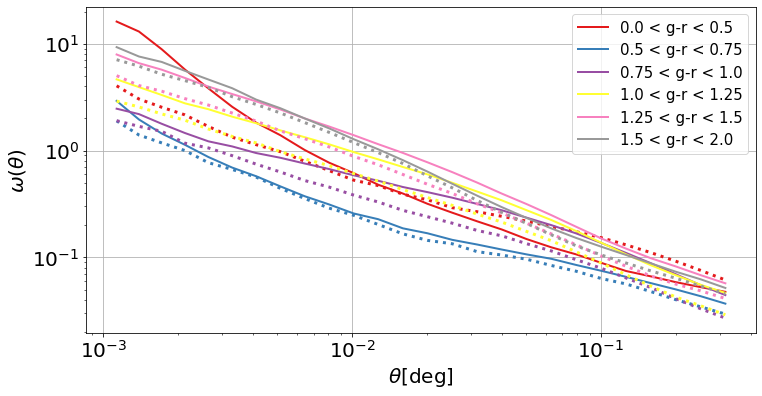

In [33]:
#
from matplotlib.pyplot import cm

fig = plt.figure(figsize=(12,6))
color=cm.Set1(np.linspace(0,1,len(colours)))

#
N = 26

clist = ['0.0_0.5', '0.5_0.75', '0.75_1.0', '1.0_1.25', '1.25_1.5', '1.5_2.0']
#clist = ['0.0_0.5', '0.5_0.75', '1.5_2.0']
#cmap = plt.get_cmap('jet', len(clist))
for num, key in enumerate(clist):
    
    ini, fin = key.split('_')
    
    plt.loglog(ac_bgs['bs'][:N], ac_bgs['w_%s' %(key)][:N], lw=2, color=color[num], label='%s < g-r < %s' %(ini, fin))
    plt.loglog(ac_mxxl['bs'][:N], ac_mxxl['w_%s' %(key)][:N], lw=3, color=color[num], ls=':')

    #plt.legend(bbox_to_anchor=(1.1, 1.05))
    
plt.xlabel(r'$\theta$[deg]', fontsize=20)
plt.ylabel(r'$\omega(\theta)$', fontsize=20)
plt.legend(fontsize=15)
plt.grid()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
filefig = os.path.join('/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/clustering/figures/', 'angular_clustering_color_bgs_mxxl')
fig.savefig(filefig+'.png', bbox_inches = 'tight', pad_inches = 0, dpi=300)


In [34]:
df = np.load('/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/alice/dr9-south_sweep_129.0_141.0_-2.0_3.0.npy')

In [65]:
from astropy.io import fits
import pandas as pd
from astropy.table import Table
import fitsio

In [42]:
df

array([(9010, 325124, '1291m010',   33, 'REX', 129.00006249, -0.92822873, 3.0490168e+09, 2.9517368e+09, [  224.64188 ,   265.19983 ,   266.58795 ,   266.69867 ,     0.      ], 0.03584304, 0.42263407, 0.6799863 ,  0.93561   ,  5.7474017 ,  5.132597  , 321.3204  ,  534.22217,  706.64734, 218.94592,  44.701164, 2.6548147, 0.62975335, 0.00061928, 8.7027101e-06, 0.8993323 , 0.931022 , 0.96081024, 0.9939441 , 0.9962765 , 0.9992047 , 0.99969965, 3, 3, 3, 177, 176,  9, 10, 1.0033048 , 0.9431561, 1.0264645 ,  2.1460605, 0.9375803 , 0.5000633 , 0.07809797, 0.04210026, 0.06189403, 0.10700689,  5.3799553 ,  4.691499  , 0.89478296, 2.0263662, 0.0098761 , 0.00926504, 0.00685873, 0.99481344, 0.9950864 , 0.99570274, 0, 0, 0, 0, 0, 0, 0, 0, 1.5408294, 1.3193601, 0.98998857, 1381.1266, 514.21564, 134.55984 ,  893.4725 , 290.26407, 60.215775, 4.2353525, 0.7921212 , '1285m016', 0.5997493 ,  280.86743, 0., 0., 0., 0., 0.19107321, 0.30742234,  0.42299002, 0.19126353, 0.308055  ,  0.42435953, '  ', 0, 0., 0.

In [ ]:
# Create a dictionary of data
dfdict = {col:df[col] for col in df.dtype.names}
#convert data to astropy Table format
tab = Table(dfdict)
#save astropy table to fits file
filename = '/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/alice/dr9-south_sweep_129.0_141.0_-2.0_3.0.fits'
tab.write(filename, format='fits')

In [68]:
df0 = fitsio.read('/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/alice/dr9-south_sweep_129.0_141.0_-2.0_3.0.fits')